In [1]:
# Link to resources
import os, sys
CWD_PATH = '/home/jovyan/work/'
sys.path.insert(0, CWD_PATH)

In [2]:
# local imports
from resources.common import swap_target_column_to_end
from resources.data_splitting import (
    create_train_and_test_dataset, 
    split_dataset_to_features_and_target,
)
from resources.normalizer import MinMaxNormalizer
from resources.plotting import plot
from resources.predictions import StandardPredictor
from resources.sequence_creator import (
    split_multivariate_dataframe_to_sequences,
)

In [3]:
# standards
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# deep learning
from keras import models, layers

# learn process visualition
from livelossplot.inputs.tf_keras import PlotLossesCallback

---

### Preprocess data before modelling

<span style="color:red">CONSTANTS</span>

In [4]:
# constants
n_steps = 50

In [5]:
# read csv
df = pd.read_csv(os.path.join(CWD_PATH, 'data/BTC_samples_1M_5m.csv'))

In [6]:
# split dataset to 
X, y = split_dataset_to_features_and_target(df, 'close')

Finded columns:
 - Day
 - Hour
 - Minute
 - Month
 - Week
 - Weekday
 - Year
 - close
 - high
 - low
 - quote_av
 - trades
 - volume


In [7]:
# create train and test dataset
X_train, X_test, y_train, y_test = create_train_and_test_dataset(X, y, percent=0.9)

Features have 8928 samples, which shape is (8928, 12).
Targets have 8928 samples, which shape is (8928, 1).

Train set have 8035 samples, test set have 893 samples


In [8]:
# data normalization
normalizer = MinMaxNormalizer()
scalers, datasets = \
    normalizer.normalize(X_train, X_test, y_train, y_test)

x_scaler, y_scaler = scalers
X_train, X_test, y_train, y_test = datasets

In [9]:
# create sequences
# concatenate vertically
X = np.vstack([X_train, X_test])
# concatenate vertically
y = np.vstack([y_train, y_test])
# concatenate horizontally
dataset = np.hstack([X, y])
# create sequences
X, y = split_multivariate_dataframe_to_sequences(dataset, n_steps)

Dataset entry shape (8928, 13)
Features shape after process: (8879, 50, 12)
Targets shape after process: (8879,)


__Above is a big problem, because we removed some samples due processing. So there is a part with wrong normalized data__

In [10]:
# one more time create train and test dataset
X_train, X_test, y_train, y_test = create_train_and_test_dataset(X, y)

Features have 8879 samples, which shape is (8879, 50, 12).
Targets have 8879 samples, which shape is (8879,).

Train set have 7103 samples, test set have 1776 samples


---

### Extra preprocess 

<span style="color:red">CONSTANTS</span>

In [11]:
# constants
n_features = X_train.shape[2]
n_seq = 2
epochs = 5
batch_size = 128

In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
X_train = X_train.reshape(
    (X_train.shape[0], n_seq, 1, n_steps // n_seq, n_features)
)
X_test = X_test.reshape(
    (X_test.shape[0], n_seq, 1, n_steps // n_seq, n_features)
)

---

### MODELLING

In [13]:
def define_model(n_steps, n_features):
    model = models.Sequential()
    model.add(
        layers.ConvLSTM2D(
            filters=64, 
            kernel_size=(1, 2),
            activation='relu',
            input_shape=(n_seq, 1, n_steps // n_seq, n_features)
        )
    )
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [14]:
model = define_model(n_steps, n_features)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 24, 64)         39168     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
_________________________________________________________________


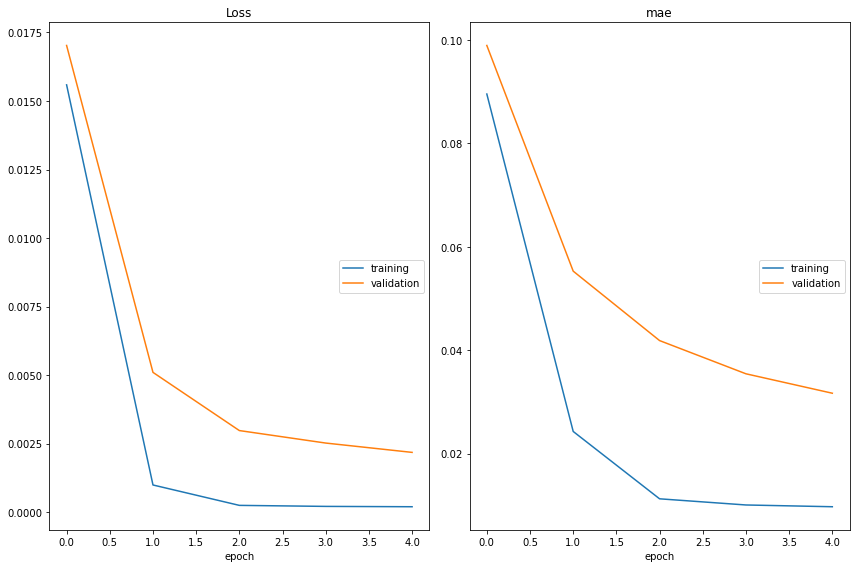

Loss
	training         	 (min:    0.000, max:    0.016, cur:    0.000)
	validation       	 (min:    0.002, max:    0.017, cur:    0.002)
mae
	training         	 (min:    0.010, max:    0.090, cur:    0.010)
	validation       	 (min:    0.032, max:    0.099, cur:    0.032)
45/45 [==============================] - 2s 40ms/step - loss: 1.9666e-04 - mae: 0.0097 - val_loss: 0.0022 - val_mae: 0.0317


In [16]:
model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[PlotLossesCallback()]
)

---

### Predictions

In [17]:
predictor = StandardPredictor(model, y_scaler)
plot_data_generator = predictor.predict(X_test, y_test=y_test, samples=12*24)

In [ ]:
plot(plot_data_generator)

Size of dataset using for predictions: 1776.
